In [59]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Используем данными о первых пяти минутах матча игры Dota, чтобы предсказать его исход, то есть определить команду победителя. Необходимые признаки записаны в файле `features.csv`:

In [62]:
data = pd.read_csv('./features.csv', index_col='match_id')
data.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [66]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97230 entries, 0 to 114406
Columns: 108 entries, start_time to barracks_status_dire
dtypes: float64(12), int64(96)
memory usage: 80.9 MB
None


Заменим все пропуски в данных на `0`:

In [37]:
data.fillna(0)

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114402,1450265551,1,47,4,1706,1198,17,0,1,8,...,4,3,0,-24.0,2032,0,1792,1975,48,63
114403,1450277704,0,43,4,1793,1416,17,0,1,5,...,3,2,0,-17.0,1734,1,2038,6,63,3
114404,1450291848,1,98,4,1399,540,1,0,0,5,...,1,3,1,-15.0,2906,0,1796,1846,51,63


Целевая переменная `radiant_win`.
Удалим признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке):

In [38]:
data.drop(['duration', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire'], axis=1, inplace=True)
y_train = data["radiant_win"]
X_train = data.drop('radiant_win', axis=1)

Приведем признаки к единому масштабу:

In [51]:
X_train.fillna(0, inplace = True)

scaler = StandardScaler()
scaler.fit(X_train)
X_normalized = scaler.transform(X_train)
X_normalized = pd.DataFrame(X_normalized, columns=X_train.columns, index = X_train.index)

Зафиксируем генератор разбиений для кросс-валидации по 5 блокам (`KFold`), перемешаем при этом выборку (`shuffle=True`), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества

In [40]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)

Построим модель логистической регресии. Подберем налучший параметр регуляризации `C` и оценим полученное качество с помощью кросс-валидации 

In [67]:
C_param_range = np.array([0.0001,0.001,0.01,0.1,1,10,100,1000])

for i in C_param_range:
    lr = LogisticRegression(C = i, random_state = 0)
    lr.fit(X_normalized, y_train)
    
    score = cross_val_score(lr, X_normalized, y_train, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    print("C:", i)
    print("Score:", score)

C: 0.0001
Score: 0.7111598481541285
C: 0.001
Score: 0.7160945676853363
C: 0.01
Score: 0.7162556488396082
C: 0.1
Score: 0.7162278323009181
C: 1.0
Score: 0.7162238717590099
C: 10.0
Score: 0.716223198504357
C: 100.0
Score: 0.7162229951346128
C: 1000.0
Score: 0.7162229972634537


Наилучшее значение показателя `cross_val_score` достигается при `C = 0.01` и равно `0.7162556488396082`.

Среди признаков в выборке есть категориальные, которые мы использовали как числовые. Категориальных признаков в этой задаче одиннадцать. Попробуем убрать их из выборки и провести кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации.

In [57]:
X_norm_drop = X_normalized.drop(['lobby_type', 'r1_hero','r2_hero','r3_hero','r4_hero','r5_hero', 'd1_hero','d2_hero','d3_hero','d4_hero','d5_hero'], axis=1)

In [73]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)

C_param_range = np.array([0.0001,0.001,0.01,0.1,1,10,100,1000])
#scores = {}
for i in C_param_range:
    
    lr = LogisticRegression(C = i, random_state = 0)
    lr.fit(X_norm_drop, y_train)
    
    score = cross_val_score(lr, X_norm_drop, y_train, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    print("C:", i)
    print("Score:", score)
 
    #scores[i] = score

C: 0.0001
Score: 0.7111735326058011
C: 0.001
Score: 0.7161505987610914
C: 0.01
Score: 0.7163172841723874
C: 0.1
Score: 0.7162900089591753
C: 1.0
Score: 0.7162856526181904
C: 10.0
Score: 0.7162851146715985
C: 100.0
Score: 0.716285085017043
C: 1000.0
Score: 0.7162850405306902


Качество не изменилось, следовательно, удаленные признаки никак не влияли на целевую переменную.

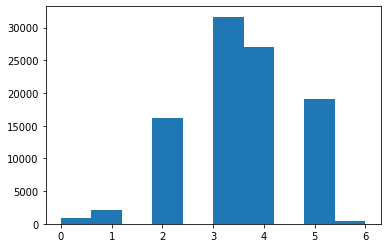

In [84]:
import matplotlib.pyplot as plt

plt.hist(data['r1_level'])
plt.show()

In [88]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size=0.3,random_state=0)

In [89]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [94]:
lr = LogisticRegression(C = 0.01, random_state = 0)
lr.fit(X_train_std, y_train)
    
y_pred = lr.predict(X_test_std)

In [96]:
from sklearn.metrics import roc_auc_score
print ("AUC-ROC = ", roc_auc_score(y_test, y_pred))

AUC-ROC =  0.6528077175055464


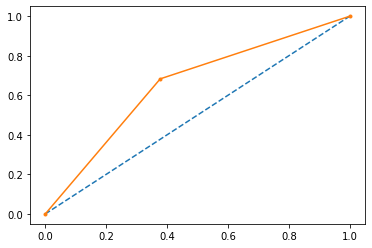

In [97]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()